Create a TS+biology tracers initial file for one bathymetry based on a restart file from a different bathymetry

In [3]:
import netCDF4 as nc
import xarray as xr
import numpy as np 

from salishsea_tools import nc_tools

%matplotlib inline

# New Bathymetry (via its mesh mask)

In [ ]:
mesh = nc.Dataset('/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/mesh_mask_202310.nc')
mbathy = mesh.variables['mbathy'][0,:,:]
#used to calculate number of vertical ocean grid cells at each (i,j) (1=land point)
gdepw = mesh.variables['gdepw_0'][0,:,:,:]
surface_tmask = mesh.variables['tmask'][0,0,:,:]
surface_tmask = np.abs(surface_tmask-1)
tmask = mesh.variables['tmask'][0,:,:,:]
tmask = np.abs(tmask-1)
lats = mesh.variables['nav_lat'][:]
lons = mesh.variables['nav_lon'][:]
mesh.close()

In [ ]:
# calculate bathymetry based on meshmask
NEMO_bathy = np.zeros(mbathy.shape)
for i in range(NEMO_bathy.shape[1]):
    for j in range(NEMO_bathy.shape[0]):
        level = mbathy[j,i]
        NEMO_bathy[j,i] = gdepw[level,j,i]
NEMO_bathy = np.ma.masked_array(NEMO_bathy, mask = surface_tmask)

# Old Bathymetry (based on its mesh mask)

In [ ]:
oldmesh = nc.Dataset('/ocean/atall/MOAD/grid/mesh_mask202108.nc')
oldmbathy =oldmesh.variables['mbathy'][0,:,:] 
#used to calculate number of vertical ocean grid cells at each (i,j) (1=land point)
oldgdepw = oldmesh.variables['gdepw_0'][0,:,:,:]
oldsurface_tmask = oldmesh.variables['tmask'][0,0,:,:]
oldsurface_tmask = np.abs(oldsurface_tmask-1)
oldtmask = oldmesh.variables['tmask'][0,:,:,:]
oldtmask = np.abs(oldtmask-1)
oldmesh.close()

In [ ]:
np.max(oldmbathy)

# Restart Files to Get Tracers (TS and Biology)

In [ ]:
#dataphys = nc.Dataset('/results2/SalishSea/nowcast-green.201905/31oct14/SalishSea_03021840_restart.nc')
#databio = nc.Dataset('/home/sallen/MEOPAR/ANALYSIS/analysis-susan/notebooks/Hindcast_202007/SalishSea_ZCil_lowNSi_03021840_restart_trc.nc')

dataphys = nc.Dataset('/results2/SalishSea/nowcast-green.202111/10aug19/SalishSea_13903920_restart.nc')
databio = nc.Dataset('/results2/SalishSea/nowcast-green.202111/10aug19/SalishSea_13903920_restart_trc.nc')   

In [ ]:
physical = ['tn', 'sn',
           'tb', 'sb']
biological = ['TRNDON', 'TRNMICZ','TRNMYRI','TRNNH4','TRNNO3','TRNTRA',
              'TRNPHY','TRNDIAT','TRNPON','TRNSi','TRNbSi',
              'TRNDIC', 'TRNTA', 'TRNO2',
             'TRBDON', 'TRBMICZ','TRBMYRI','TRBNH4','TRBNO3','TRBTRA',
              'TRBPHY','TRBDIAT','TRBPON','TRBSi','TRBbSi',
             'TRBDIC', 'TRBTA', 'TRBO2']
varas = {}
for vb in physical:
    varas[vb] = dataphys.variables[vb][0, :]
for vb in biological:
    print (vb)
    varas[vb] = databio.variables[vb][0, :]
#dataphys.close()
#databio.close()
varall = physical + biological

# Fill in any Missing Data Points

In [ ]:
def find_mean(varas, varall, i, j, k, dd, oldtmask):
    for vb in varall:
        imin = max(i-dd, 0)
        imax = min(i+dd, 897)
        jmin = max(j-dd, 0)
        jmax = min(j+dd, 397)
        temporary = np.sum(varas[vb][k, imin:imax+1, jmin:jmax+1]*(1-oldtmask[k, imin:imax+1, jmin:jmax+1]))
        count = np.sum(1-oldtmask[k, imin:imax+1, jmin:jmax+1])
        if count == 0:
            varas[vb][k, i, j] = 0
        else:
            varas[vb][k, i, j] = temporary/count
    return varas

In [ ]:
def fillit(kmax, oldtmask, varas, varall):
    dd = 1
    bad = 1
    while bad > 0:
        dd += 1
        good = 1
        while good > 0:
            good = 0; bad = 0; already = 0
            for k in range(kmax+1):
                for i in range(1, 898):
                    for j in range(1, 398):
                        if tmask[k,i,j] < oldtmask[k,i,j]:
                            if varas['sn'][k, i, j] > 0:
                                already = already + 1
                            else:
                                varas = find_mean(varas, varall, i, j, k, dd, oldtmask)
                                if varas['sn'][k, i, j] > 0:
                                    good = good + 1
                                else:
                                    bad = bad + 1
                                    if dd > 5:
                                        print (k, i, j)
            print ('dd', dd, 'good', good)
            print ('already', already, 'bad', bad)

This can take a very long time if the bathymetries are very different, aka add a new long river.  If you want you can do it in pieces by starting with the first argument at say 5 and then slowly increasing it.  You do need to go to 39 finally. For new bathy201702 versus old bathy201702 its fast.

In [ ]:
fillit(39, oldtmask, varas, varall)

# Write your Initial File

In [ ]:
# build nc file
new_initialfile = nc.Dataset('restart_phybio_13903920_10aug19.nc', 'w')
nc_tools.init_dataset_attrs(
    new_initialfile, 
    title='All tracers for Bathymetry 202310 from nowcast-green 10aug19, with N and Si inc.', 
    notebook_name='/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/Initial_from_Restart_Bathy202108_from-Susan', 
    nc_filepath='/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/Bathy202108_10aug19.nc',
    comment='All Tracers, physical and biological')
new_initialfile.createDimension('y', 898)
new_initialfile.createDimension('x', 398)
new_initialfile.createDimension('z', 40)
new_initialfile.createDimension('t', None)

In [ ]:
thevara = {}
for vb in varall:
    thevara[vb] = new_initialfile.createVariable(
        vb, 'float64', ('t', 'z', 'y', 'x'), zlib=True,
        least_significant_digit=1e-5, fill_value=-99)
    thevara[vb][0] = varas[vb]
    print (vb, np.max(thevara[vb]))
new_initialfile

In [ ]:
new_initialfile.close()

# Copy variables in the old restart files to the new one

In [1]:
var_phy_to_copy = {'nav_lon','nav_lat','nav_lev','time_counter','rnf_b', 'sfx_b', 'rotn', 'vtau_b', 'rdttra1', 'avt', 'nav_lon', 'qns_b', 'vn', 'hdivn', 'time_counter', 'en', 'hdivb', 'sshb', 'rhop', 'ndastp', 'adatrj', 'fse3t_n', 'ssh_ibb', 'avm', 'avmu', 'mxln', 'sshn', 'sbc_sc_b', 'nav_lev', 'emp_b', 'qsr_hc_b', 'sbc_hc_b', 'rnf_sc_b', 'vb2_b', 'ub2_b', 'nav_lat', 'ub', 'rotb', 'fse3t_b', 'un', 'rdt', 'utau_b', 'fraqsr_1lev', 'avmv', 'vb', 'kt', 'rnf_hc_b'}
var_bio_to_copy = {'rnf_pis_DIC_b', 'rnf_pis_MYRI_b', 'sbc_DON_b', 'sbc_bSi_b', 'nav_lon', 'rnf_pis_PON_b', 'rnf_pis_PHY_b', 'time_counter', 'rnf_pis_MICZ_b', 'sbc_TA_b', 'rdttrc1', 'rnf_pis_TRA_b', 'ndastp', 'sbc_Si_b', 'rnf_pis_TA_b', 'adatrj', 'rnf_pis_bSi_b', 'sbc_PHY_b', 'nav_lev', 'sbc_DIC_b', 'sbc_DIAT_b', 'sbc_O2_b', 'sbc_MYRI_b', 'rnf_pis_NO3_b', 'rnf_pis_DON_b', 'sbc_MICZ_b', 'sbc_PON_b', 'sbc_NH4_b', 'rnf_pis_O2_b', 'nav_lat', 'sbc_TRA_b', 'kt', 'rnf_pis_DIAT_b', 'rnf_pis_Si_b', 'rnf_pis_NH4_b', 'sbc_NO3_b'}

In [27]:
dfphy = xr.open_dataset('SalishSea_13903920_restart.nc') # Copy from /results2/SalishSea/nowcast-green.202111/10aug19/
dfbio = xr.open_dataset('SalishSea_13903920_restart_trc.nc') # same as above
dfnew = xr.open_dataset('restart_phybio_13903920_10aug19.nc')

In [28]:
dfnew[var_phy_to_copy]=dfphy[var_phy_to_copy]
dfnew[var_bio_to_copy]=dfbio[var_bio_to_copy]
dfnew

<xarray.Dataset>
Dimensions:         (t: 1, z: 40, y: 898, x: 398)
Dimensions without coordinates: t, z, y, x
Data variables: (12/104)
    tn              (t, z, y, x) float64 ...
    sn              (t, z, y, x) float64 ...
    tb              (t, z, y, x) float64 ...
    sb              (t, z, y, x) float64 ...
    TRNDON          (t, z, y, x) float64 ...
    TRNMICZ         (t, z, y, x) float64 ...
    ...              ...
    sbc_O2_b        (t, y, x) float64 ...
    rnf_pis_DIAT_b  (t, y, x) float64 ...
    rnf_pis_TRA_b   (t, y, x) float64 ...
    sbc_TA_b        (t, y, x) float64 ...
    sbc_NH4_b       (t, y, x) float64 ...
    sbc_bSi_b       (t, y, x) float64 ...
Attributes:
    Conventions:  CF-1.6
    title:        All tracers for Bathymetry 202310 from nowcast-green 10aug1...
    institution:  Dept of Earth, Ocean & Atmospheric Sciences, University of ...
    source:       REQUIRED
    references:   REQUIRED
    history:      [2023-10-25 18:30:34] Created netCDF4 zlib=True dataset.
    comment:      All Tracers, physical and biological

In [ ]:
dfnew.to_netcdf('restart_PHYBIO_13903920_10aug19_202310.nc', mode='w')

In [91]:
#
Sn = dfnew.variables['sn']
Sb = dfnew.variables['sb']
Sn.shape

(1, 40, 898, 398)

In [92]:
kk = np.arange(1, 40)
jj = np.arange(0, 898)
ii = np.arange(0, 398)
# box where changes took place (in all salish sea takes too much time, and not necessary I think)
pointsi = np.arange(200, 250).astype(int)
pointsj = np.arange(350, 380).astype(int)

#SSn = np.ones((1, 40, 898, 398))
for k in kk:
    for j in pointsj:
        for i in pointsi:
            diffsn = Sn[:, k, j, i] - Sn[:, k-1, j, i]
            if diffsn < 0:
                Sn[:, k, j, i] = Sn[:, k-1, j, i]
#            else:
#                sn[:, k, j, i] = sn[:, k, j, i]

sn.shape


(1, 40, 898, 398)

In [93]:
for k in kk:
    for j in pointsj:
        for i in pointsi:
            diffsb = Sb[:, k, j, i] - Sb[:, k-1, j, i]
            if diffsb < 0:
                Sb[:, k, j, i] = Sb[:, k-1, j, i]

sb.shape

(1, 40, 898, 398)

In [94]:
dfnew2 = dfnew
dfnew2['sn'] = Sn
dfnew2['sb'] = Sb


In [96]:
dfnew2.to_netcdf('restart_PHYBIO_13903920_10aug19_202310_snsbCorrected.nc', mode='w')

In [97]:
dfA = xr.open_dataset('restart_PHYBIO_13903920_10aug19_202310.nc')
dfB = xr.open_dataset('restart_PHYBIO_13903920_10aug19_202310_snsbCorrected.nc')
snA = dfA['sn']
snB = dfB['sn']

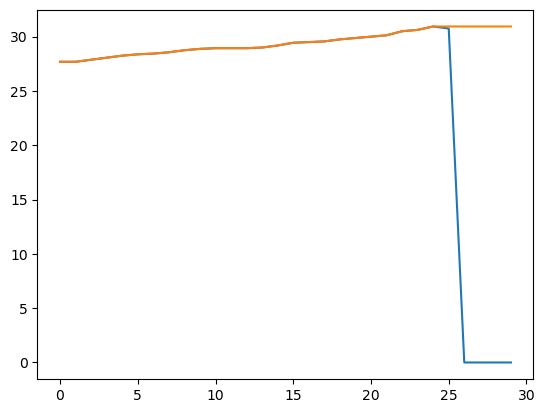

In [98]:
import matplotlib.pyplot as plt
plt.plot(snA[0, :30, 363, 235])
plt.plot(snB[0, :30, 363, 235])
